In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
# to play the audio files
from IPython.display import Audio
import subprocess


In [3]:
lang_audio= "/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset"

In [ ]:
f=0
for dirname, folder, filenames in os.walk('/kaggle/input'):
        f+= len(filenames)
        print(dirname , ' : ' , len(filenames))
print("Total samples: ",f )
print("Avg samples per language: ",f/10 )

In [5]:
languages = os.listdir(lang_audio)
file_paths = []
dir_paths=[]
for dirs in languages:
    files = os.listdir(lang_audio +"/"+ dirs)
    dir_paths.append(lang_audio +"/"+ dirs)
    for f in files:
        file_paths.append(lang_audio + dirs + '/' + f)

languages_df = pd.DataFrame(languages, columns=['Language'])

path_df = pd.DataFrame(dir_paths, columns=['Path'])
dataset_df = pd.concat([languages_df, path_df], axis=1)


In [6]:
dataset_df

,Language,Path
0,Punjabi,/kaggle/input/audio-dataset-with-10-indian-lan...
1,Tamil,/kaggle/input/audio-dataset-with-10-indian-lan...
2,Hindi,/kaggle/input/audio-dataset-with-10-indian-lan...
3,Bengali,/kaggle/input/audio-dataset-with-10-indian-lan...
4,Telugu,/kaggle/input/audio-dataset-with-10-indian-lan...
5,Kannada,/kaggle/input/audio-dataset-with-10-indian-lan...
6,Gujarati,/kaggle/input/audio-dataset-with-10-indian-lan...
7,Urdu,/kaggle/input/audio-dataset-with-10-indian-lan...
8,Marathi,/kaggle/input/audio-dataset-with-10-indian-lan...
9,Malayalam,/kaggle/input/audio-dataset-with-10-indian-lan...


In [144]:


def create_waveplot(data, sr, language):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for {language} audio', size=15)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(audio, sr):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Normalize spectrogram
    spectrogram = (spectrogram - np.mean(spectrogram)) / np.std(spectrogram)
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.show() 
    
def plot_audio(input_path,sr=44100,duration=5.0):
    audio, _ = librosa.load(input_path, sr=sr, duration=duration, mono=True)
    create_waveplot(data, sampling_rate, language)
    create_spectrogram(audio, sr)
    Audio(input_path)
    


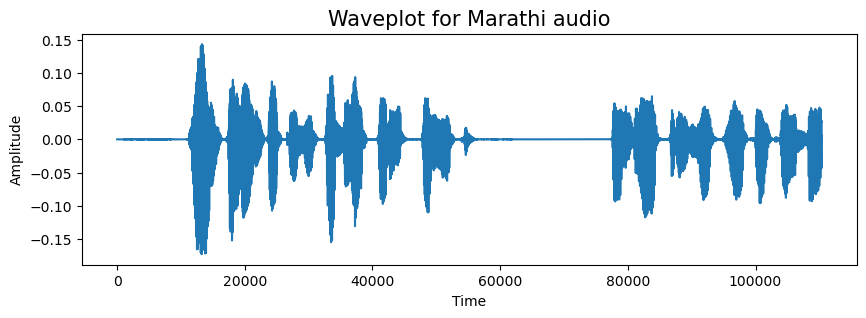

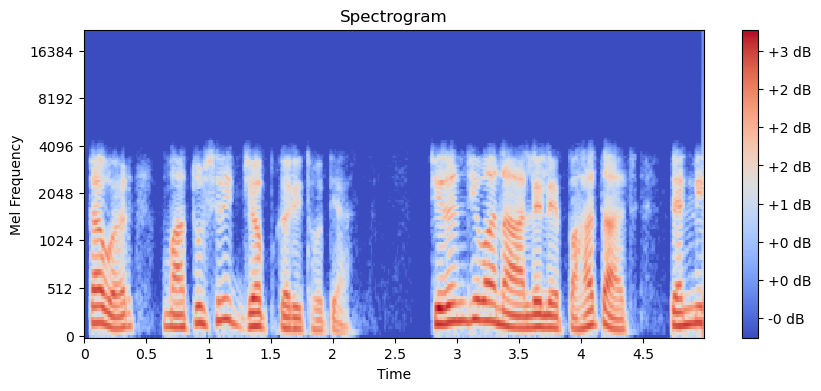

In [145]:
language='Marathi'
sr=44100
duration=5.0
path = np.array(dataset_df.Path[dataset_df.Language==language])[0]
path= path +'/'+os.listdir(path)[3]

plot_audio(path,sr=44100,duration=5.0)

  

## Remove Silences more than 0.2s

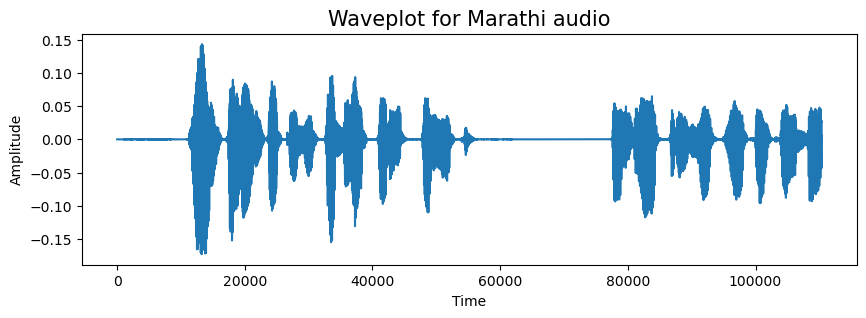

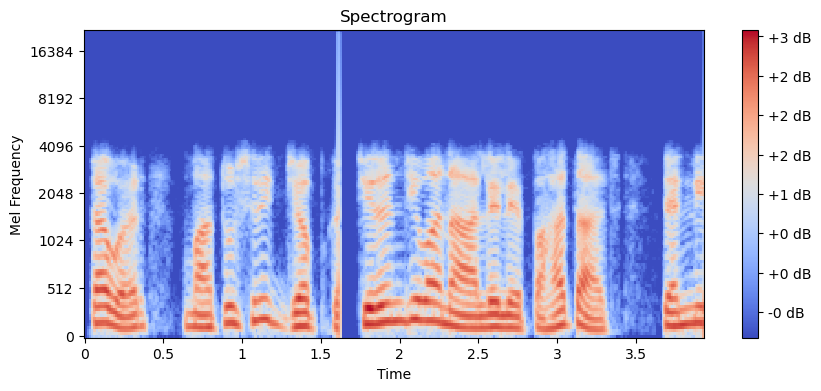

In [117]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

def remove_silences(input_file, output_file, min_silence_len=1000, silence_thresh=-40, keep_silence=200):
    audio = AudioSegment.from_file(input_file)

    chunks = split_on_silence(audio, min_silence_len=min_silence_len, silence_thresh=silence_thresh, keep_silence=keep_silence)

    output = chunks[0].set_channels(1)
    for chunk in chunks[1:]:
        output += chunk.set_channels(1)

    output.export(output_file, format='wav')


input_file = path
output_file = '/kaggle/working/output_audio.wav'

remove_silences(input_file, output_file)

plot_audio(output_file)


 





# Data Augmentation TECHNIQUES

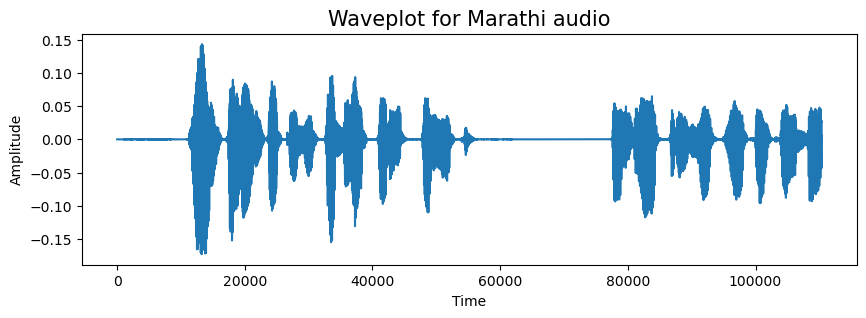

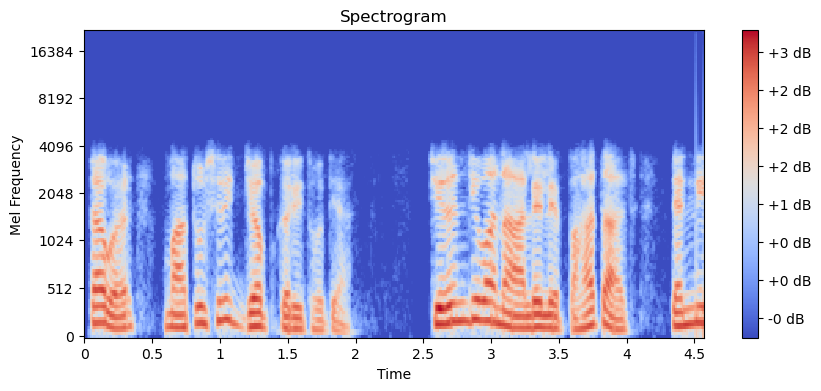

In [118]:
#Speed Perturbation
import random
from pydub import effects

input_file = path
output_file = '/kaggle/working/output_audio.wav'

speed_range=(0.9, 1.1)
audio = AudioSegment.from_file(input_file)
speed_factor = random.uniform(speed_range[0], speed_range[1])
augmented_audio = effects.speedup(audio, speed_factor)
augmented_audio.export(output_file, format='wav')

plot_audio(output_file)

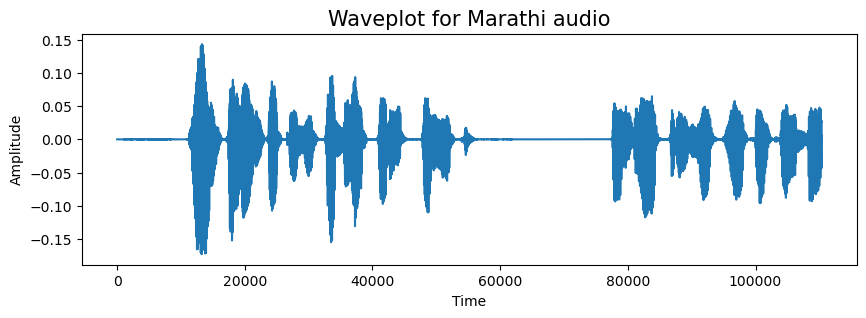

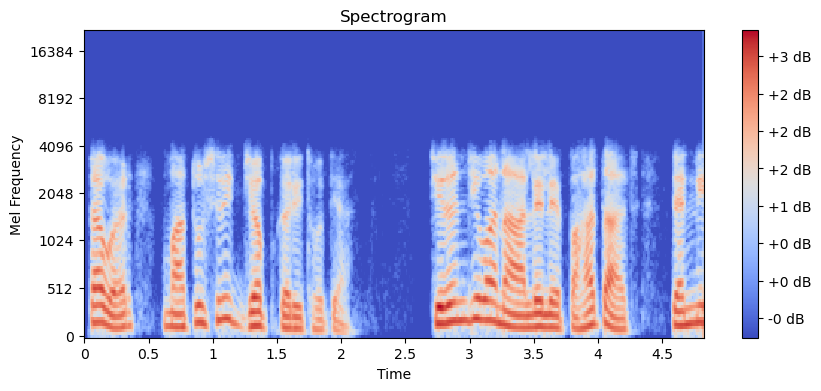

In [127]:
input_file = path
output_file = '/kaggle/working/output_audio.wav'
sr=44100
pitch_range=(-2, 2)
audio = AudioSegment.from_file(input_file)


def pitch_shifting(audio, pitch_range=(-2, 2)):
    pitch_semitones = random.uniform(pitch_range[0], pitch_range[1])
    return audio._spawn(audio.raw_data, overrides={
        "frame_rate": int(audio.frame_rate * (2.0 ** (pitch_semitones / 12.0)))
    })



# Apply pitch shifting
augmented_audio = pitch_shifting(audio)

# Export the augmented audio
augmented_audio.export(output_file, format='wav')

# Plot the augmented audio waveform
plot_audio(output_file)
Audio(output_file)


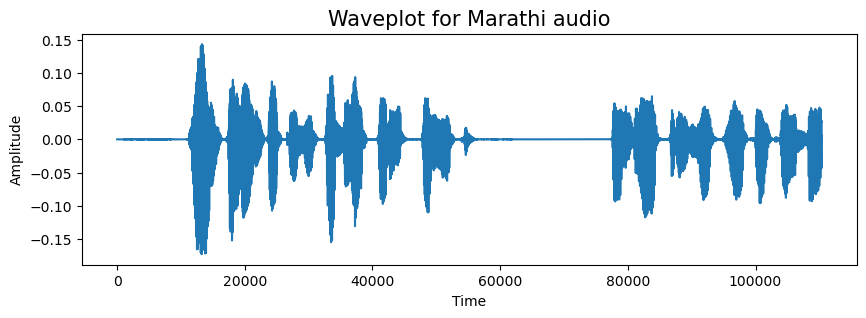

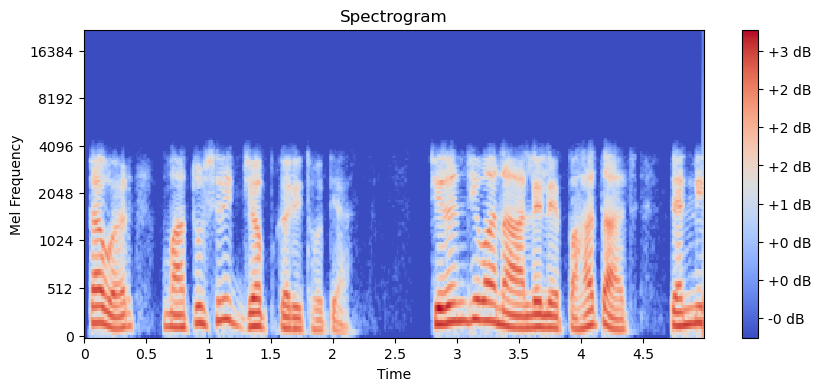

In [148]:
input_file = path
output_file = '/kaggle/working/output_audio.wav'
sr=44100
audio = AudioSegment.from_file(input_file)


from pydub import AudioSegment
import numpy as np

def generate_white_noise(duration, sr):
    samples = np.random.randn(int(duration * sr))
    samples /= np.max(np.abs(samples))
    return samples

def add_white_noise(input_file, output_file, noise_level):
    # Load the input audio file
    audio = AudioSegment.from_file(input_file)

    # Generate white noise
    white_noise = generate_white_noise(len(audio) / 1000, audio.frame_rate)

    # Scale the white noise based on the desired noise level
    scaled_noise = noise_level * np.array(white_noise)

    # Create a new AudioSegment for the noise
    noise_audio = AudioSegment(
        data=scaled_noise.astype(np.int16).tobytes(),
        sample_width=audio.sample_width,
        frame_rate=audio.frame_rate,
        channels=audio.channels
    )

    # Add the noise to the input audio
    noisy_audio = audio.overlay(noise_audio)

    # Export the noisy audio
    noisy_audio.export(output_file, format='wav')

# Set the parameters
input_file = path
output_file = '/kaggle/working/output_audio.wav'
noise_level = 0.9

# Add white noise to the audio
add_white_noise(input_file, output_file, noise_level)

# Plot the augmented audio waveform
plot_audio(output_file)
Audio(output_file)

In [ ]:
## Create a new dataset with 100 samples each (Total 10,000 samples)
## with 1000 samples each (100,000 samples)

In [22]:
import random

def generateDataset(k, lang_audio= '/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset' ):
    r_nums = [random.randint(1, 20000) for _ in range(k)]
    file_language = os.listdir(lang_audio)
    selectKfiles = pd.DataFrame(columns=file_language)
    
    for lang_dir in file_language:
        files = [os.path.join(lang_audio, lang_dir, str(num) + '.mp3') for num in r_nums]
        selectKfiles[lang_dir] = files
    
    selectKfiles.to_csv(f"{k}_samples.csv", index=False)
    print(f"{k}_samples.csv has been generated.")

# Usage example
generateDataset(100)
generateDataset(1000)
generateDataset(10000)


100_samples.csv has been generated.
1000_samples.csv has been generated.
10000_samples.csv has been generated.


In [ ]:
audio, _ = librosa.load(audio_path, sr=sr, duration=duration, mono=True)
# Compute spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            
# Normalize spectrogram
spectrogram = (spectrogram - np.mean(spectrogram)) / np.std(spectrogram)